# Quantum Satellite Placement

This quantum algorithm explores the problem of optimally grouping a set of satellites into constellations to observe specific targets on Earth. Each satellite has unique observational capabilities, influencing how effectively it can monitor a designated area for a certain duration. The goal of the algorithm is to demonstrate quantum superiority on how to maximize the Earth coverage of each constellation, ensuring that all targets are monitored as efficiently as possible.

In [2]:
import itertools
import json
import math
import sys
import matplotlib.pyplot as plt
import dimod
import dynex
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

## Helper functions

In [4]:
def calculate_score(constellation, data):
    """ Function to calculate constellation score."""

    score = 1
    for v in constellation:
        score *= (1 - data['coverage'][str(v)])
    score = 1 - score
    return score

In [5]:
def build_bqm(data, constellation_size):
    """ Build the bqm for the problem."""

    # don't consider constellations with average score less than score_threshold
    score_threshold = .4

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    # first we want to favor combinations with a high score
    for constellation in itertools.combinations(range(data['num_satellites']), constellation_size):
        # the score is the probability of at least one satellite in the constelation having line of sight over the target at any one time.
        score = calculate_score(constellation, data)

        # to make it smaller, throw out the combinations with a score below
        # a set threshold
        if score < score_threshold:
            continue

        # we subtract the score because we want to minimize the energy
        bqm.add_variable(frozenset(constellation), -score)

    # next we want to penalize pairs that share a satellite. We choose 2 because
    # because we don't want it to be advantageous to pick both in the case that
    # they both have 100% coverage
    for c0, c1 in itertools.combinations(bqm.variables, 2):
        if c0.isdisjoint(c1):
            continue
        bqm.add_interaction(c0, c1, 2)

    # finally we wish to choose num_constellations variables. We pick strength of 1
    # because we don't want it to be advantageous to violate the constraint by
    # picking more variables
    bqm.update(dimod.generators.combinations(bqm.variables, data['num_constellations'], strength=1))

    return bqm

In [167]:
def getImage(path, zoom=1):
    return OffsetImage(plt.imread(path), zoom=zoom)

def viz(constellations, data):
    """ Visualize the solution"""
    
    angle = 2*math.pi / data["num_satellites"]
    plt.figure(figsize=(10,6))
    img = plt.imread("satellite-data/earth.jpg")
    
    fig = plt.figure()
    fig.patch.set_facecolor('xkcd:black')
    
    plt.title('Optimal Satellite Constellations\n'+str(data['num_satellites'])+' satellites, '+str(data['num_constellations'])+' targets to observe', color='white')
    plt.imshow(img, zorder=0, extent=[-1.5, 1.5, -1, 1])
    
    s = 0
    for c in constellations:
        x = []
        y = []
        label = []
        for satellite in c:
            coverage = 1 - data["coverage"][str(satellite)]
            label.append(satellite)
            x.append(coverage*math.cos(s*angle))
            y.append(coverage*math.sin(s*angle)+0.2)
            s += 1
    
        x.append(x[0])
        y.append(y[0])
        label.append(label[0])
        plt.plot(x, y, zorder=1, marker = 'o', markersize=10, color='white')
    plt.tight_layout()
    plt.axis('off')
    plt.show()

## Quantum Solution

In [52]:
with open('satellite-data/mini.json', 'r') as fp:
    data = json.load(fp)

In [53]:
print('Number of satellites:',data['num_satellites']);
print('Number of targets on earth to observe:',data['num_constellations']);

Number of satellites: 9
Number of targets on earth to observe: 3


In [54]:
# each of the x satellites (labelled 0..n-1) has a coverage score. This could be
# calculated as the percentage of time that the Earth region is in range of the
# satellite

constellation_size = data['num_satellites'] // data['num_constellations']

bqm = build_bqm(data, constellation_size)

In [55]:
sampleset = dynex.sample(bqm, mainnet=False, num_reads=10000, annealing_time = 1000, description='Satellite Positioning');
print(sampleset)

[DYNEX] PRECISION SET TO 0.0001
[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │       92 │            3578 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.40 SECONDS
[DYNEX] SAMPLESET READY
  frozenset({0, 1, 2}) ... frozenset({8, 6, 7})    energy num_oc.
0                    0 ...                    0 -2.922514       1
['BINARY',

Constellation: frozenset({0, 1, 5}), Score: 0.97568
Constellation: frozenset({2, 4, 6}), Score: 0.973666
Constellation: frozenset({8, 3, 7}), Score: 0.973168
Total Score: 2.922514
Normalized Score (tot / # constellations): 0.9741713333333334


<Figure size 1000x600 with 0 Axes>

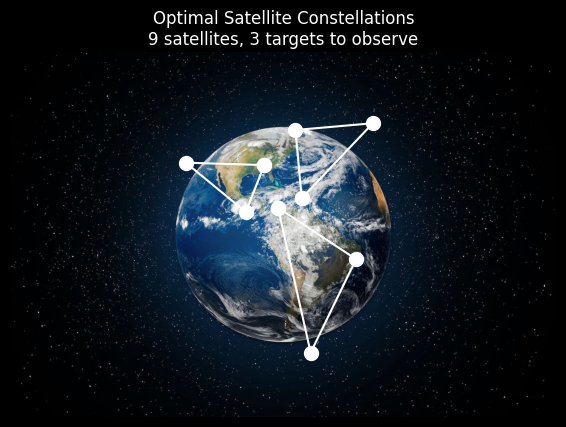

In [168]:
constellations = [constellation
                for constellation, chosen in sampleset.first.sample.items()
                if chosen]

tot = 0
for constellation in constellations:
    score = calculate_score(constellation, data)
    print("Constellation: " + str(constellation) + ", Score: " + str(score))
    tot += score
print("Total Score: " + str(tot))
print("Normalized Score (tot / # constellations): " + str((tot / data['num_constellations'])))

viz(constellations, data)